In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
from bson.json_util import dumps, loads
from time import time

client = MongoClient("localhost", 27010)
db = client.research
db.authenticate("marilu", "topsecretpasswordformarilusmongo")
db.collection_names()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  # Remove the CWD from sys.path while we load stuff.


['labelled_authors',
 'july2021_all',
 'political_leaning_07_2021',
 'tmpDlTvc.renameCollection',
 'final_db']

In [2]:
t = time()
final_db = list(db.final_db.find())
df = pd.DataFrame(final_db)
df = df.where(pd.notnull(df), None)
print('It took', round((time()-t)/60, 2), 'minutes')

It took 2.65 minutes


In [3]:
print('df shape:', str(df.shape))
#print(str(df.columns))
df.head()

df shape: (5173318, 24)


,_id,age_source_post,author_id,birth_year,created_on,female,gender_source_post,male,nationality,nationality_in_domain,...,personality_intuitive,personality_judging,personality_perceiving,personality_sensing,personality_thinking,political_leaning,political_leaning_in_domain,post_body,post_id,subreddit
0,6435b8e53b94888a0cc624c2,None,t2_4gomk5c3,None,2022-06-02 00:51:00,None,None,None,None,None,...,None,None,None,None,None,center,1,The cringe cookies,iauf7ch,r/PoliticalCompassMemes
1,6435b8e53b94888a0cc624c3,None,t2_4gomk5c3,None,2022-06-03 20:25:06,None,None,None,None,None,...,None,None,None,None,None,center,0,Incoming call from robtop 😳,ib2ddob,r/geometrydash
2,6435b8e53b94888a0cc624c4,None,t2_4gomk5c3,None,2022-06-16 20:51:08,None,None,None,None,None,...,None,None,None,None,None,center,0,Damn what texture pack is this??,icm5atj,r/geometrydash
3,6435b8e53b94888a0cc624c5,None,t2_4gomk5c3,None,2022-06-21 22:50:27,None,None,None,None,None,...,None,None,None,None,None,center,0,r/nextfuckinglevel,id841md,u/DaBabyOnReddit
4,6435b8e53b94888a0cc624c6,None,t2_92exx7h,None,2022-06-01 10:31:27,None,None,None,None,None,...,None,None,None,None,None,center,1,Lauri Törni moment,iarj37e,r/PoliticalCompassMemes


In [19]:
binary_vars = {'gender':{'male': 'male', 'female': 'female'}, 
               'personality_D1':{'extroversion': 'personality_extrovert', 'introversion': 'personality_introvert'},
               'personality_D2': {'sensors': 'personality_sensing', 'intuitives': 'personality_intuitive'},
               'personality_D3':{'thinkers': 'personality_thinking', 'feelers': 'personality_feeling'},
               'personality_D4':{'judgers': 'personality_judging', 'perceivers': 'personality_perceiving'}
              }

categorical_variables = ['nationality', 'political_leaning', 'birth_year']

n_posts_per_label = {'gender':{'male': None, 'female': None},
                     'personality_D1':{'extroversion': None, 'introversion': None},
                     'personality_D2':{'sensors': None, 'intuitives': None},
                     'personality_D3':{'thinkers': None, 'feelers': None},
                     'personality_D4':{'judgers': None, 'perceivers': None},
                     'political_leaning': {},
                     'nationality': {},
                     'birth_year': {}
                    }

percentage_posts_per_label = {'gender':[{'male': None, 'female': None}, None, None],
                              'personality_D1':[{'extroversion': None, 'introversion': None}, None, None],
                              'personality_D2':[{'sensors': None, 'intuitives': None}, None, None],
                              'personality_D3':[{'thinkers': None, 'feelers': None}, None, None],
                              'personality_D4':[{'judgers': None, 'perceivers': None}, None, None],
                              'political_leaning': [{}, None, None],
                              'nationality': [{}, None, None],
                              'birth_year': [{}, None, None]
                             }

In [20]:
# count number of posts per label (binary variables)
for attribute in binary_vars.keys():
    for label in binary_vars[attribute].keys():
        n_posts_per_label[attribute][label] = df[binary_vars[attribute][label]].sum()

In [21]:
# count number of posts per label (categorical variables)
for var in categorical_variables:
    labels = df[var].unique()
    labels = [x for x in labels if x is not None]
    if var == 'birth_year':
        labels = sorted([int(x) for x in labels])
    for label in labels:
        n_posts_per_label[var][str(label)] = df[var].value_counts()[str(label)]


In [22]:
n_posts_per_label['nationality'] = dict(sorted(n_posts_per_label['nationality'].items(),
                                               key=lambda x:x[1], reverse = True))

In [23]:
for attribute in n_posts_per_label.keys():
    tot = 0
    for label in n_posts_per_label[attribute]:
        tot+= n_posts_per_label[attribute][label]
    for label in n_posts_per_label[attribute]:
        percentage_posts_per_label[attribute][0][label] = round((n_posts_per_label[attribute][label]/tot)*100, 2)
        percentage_posts_per_label[attribute][1] = round(tot)
        percentage_posts_per_label[attribute][2] = round((tot/len(df))*100, 2)

In [24]:
percentage_posts_per_label['birth_year'][0] = dict(sorted(percentage_posts_per_label['birth_year'][0].items(),
                                               key=lambda x:x[1], reverse = True))

In [25]:
# each attribute lists contain percentage of specific labels in the attribute's total posts, 
#number of posts of that attribute, percentage occupied by that attribute in the df (NB. personality is 5% in total)
percentage_posts_per_label

{'gender': [{'male': 47.91, 'female': 52.09}, 381056.0, 7.37],
 'personality_D1': [{'extroversion': 26.52, 'introversion': 73.48},
  280602.0,
  5.42],
 'personality_D2': [{'sensors': 15.27, 'intuitives': 84.73}, 280602.0, 5.42],
 'personality_D3': [{'thinkers': 67.94, 'feelers': 32.06}, 280602.0, 5.42],
 'personality_D4': [{'judgers': 51.84, 'perceivers': 48.16}, 280602.0, 5.42],
 'political_leaning': [{'center': 41.88, 'right': 36.12, 'left': 22.0},
  3357064,
  64.89],
 'nationality': [{'Germany': 12.3,
   'United Kingdom': 10.62,
   'USA': 8.67,
   'The Netherlands': 6.59,
   'France': 4.59,
   'Sweden': 4.3,
   'Finland': 3.84,
   'Poland': 3.77,
   'Italy': 3.75,
   'Ireland': 3.28,
   'Turkey': 2.97,
   'Denmark': 2.51,
   'Portugal': 2.48,
   'Spain': 2.42,
   'Greece': 2.32,
   'Romania': 2.24,
   'Austria': 2.16,
   'Norway': 2.1,
   'Belgium': 1.89,
   'Czech Republic': 1.5,
   'Hungary': 1.42,
   'Croatia': 1.32,
   'Bulgaria': 1.19,
   'Switzerland': 1.1,
   'Canada': 1.09

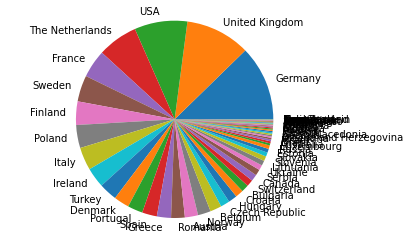

In [26]:
# Plot nationalities
labels = []
sizes = []

for x, y in n_posts_per_label['nationality'].items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels, radius = 10)

plt.axis('equal')
plt.show()

In [33]:
#df['birth_year'].astype('int', errors='ignore')[5173304].describe()
birth_year = [int(x) for x in list(df['birth_year']) if x is not None]
pd.DataFrame({'col':birth_year})['col'].describe()

count    381056.000000
mean       1989.160165
std          12.343291
min        1922.000000
25%        1982.000000
50%        1992.000000
75%        1998.000000
max        2011.000000
Name: col, dtype: float64

<BarContainer object of 70 artists>

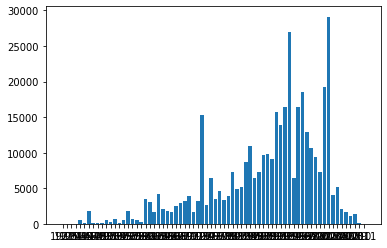

In [27]:
# Plot birth year
plt.bar(n_posts_per_label['birth_year'].keys(), n_posts_per_label['birth_year'].values())

# Posts length

In [38]:
# posts length
posts_length = []
for post in df['post_body']:
    n = len(post.split())
    posts_length.append(n)

In [48]:
pd.DataFrame({'l':posts_length})['l'].describe()

count    5.173318e+06
mean     3.269285e+01
std      5.428381e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.700000e+01
75%      3.800000e+01
max      2.867000e+03
Name: l, dtype: float64

In [75]:
postsLength_per_label = {'gender':{'male': None, 'female': None},
                         'personality_D1':{'extroversion': None, 'introversion': None},
                         'personality_D2':{'sensors': None, 'intuitives': None},
                         'personality_D3':{'thinkers': None, 'feelers': None},
                         'personality_D4':{'judgers': None, 'perceivers': None},
                         'political_leaning': {},
                         'nationality': {},
                         'birth_year': {}
                        }

In [76]:
# count number of posts per label (binary variables)
for attribute in binary_vars.keys():
    for label in binary_vars[attribute].keys():
        posts = df.loc[df[binary_vars[attribute][label]] == 1, 'post_body']
        posts_length = []
        for post in posts:
            n = len(post.split())
            posts_length.append(n)
        measures = {}
        measures['mean'] = round(stats.mean(posts_length), 2)
        measures['median'] = round(stats.median(posts_length), 2)
        measures['st.dv'] = round(stats.pstdev(posts_length), 2)
        measures['min'] = min(posts_length)
        measures['max'] = max(posts_length)
        
        postsLength_per_label[attribute][label] = measures

In [79]:
# count number of posts per label (categorical variables)
for attribute in categorical_variables:
    labels = df[attribute].unique()
    labels = [x for x in labels if x is not None]
    if attribute == 'birth_year':
        labels = sorted([int(x) for x in labels])
    for label in labels:
        posts = df.loc[df[attribute] == str(label), 'post_body']
        posts_length = []
        for post in posts:
            n = len(post.split())
            posts_length.append(n)
        measures = {}
        measures['mean'] = round(stats.mean(posts_length), 2)
        measures['median'] = round(stats.median(posts_length), 2)
        measures['st.dv'] = round(stats.pstdev(posts_length), 2)
        measures['min'] = min(posts_length)
        measures['max'] = max(posts_length)
        
        postsLength_per_label[attribute][label] = measures
    

In [80]:
postsLength_per_label

{'gender': {'male': {'mean': 48.18,
   'median': 18.0,
   'st.dv': 123.12,
   'min': 1,
   'max': 1896},
  'female': {'mean': 51.83,
   'median': 33.0,
   'st.dv': 68.92,
   'min': 1,
   'max': 1775}},
 'personality_D1': {'extroversion': {'mean': 33.17,
   'median': 15,
   'st.dv': 58.06,
   'min': 1,
   'max': 1668},
  'introversion': {'mean': 33.36,
   'median': 15,
   'st.dv': 59.73,
   'min': 1,
   'max': 1668}},
 'personality_D2': {'sensors': {'mean': 29.34,
   'median': 13.0,
   'st.dv': 51.44,
   'min': 1,
   'max': 1668},
  'intuitives': {'mean': 34.03,
   'median': 15.0,
   'st.dv': 60.57,
   'min': 1,
   'max': 1668}},
 'personality_D3': {'thinkers': {'mean': 31.77,
   'median': 14,
   'st.dv': 55.85,
   'min': 1,
   'max': 1668},
  'feelers': {'mean': 36.58,
   'median': 16,
   'st.dv': 65.88,
   'min': 1,
   'max': 1603}},
 'personality_D4': {'judgers': {'mean': 35.0,
   'median': 16.0,
   'st.dv': 62.3,
   'min': 1,
   'max': 1582},
  'perceivers': {'mean': 31.5,
   'media